In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
df = pd.read_csv("data/SCFP2019.csv.gz")

In [ ]:
mask = df["TURNFEAR"] == 1
mask.sum()

4623

In [ ]:
mask = df["TURNFEAR"] == 1
df_fear = df[mask]

# df_fear shape: (4623, 351)

## Age

In [ ]:
age_groups = df_fear["AGECL"].unique()
print("Age Groups:", age_groups)

Looking at the Code Book we can see that `"AGECL"` represents categorical data, even though the values in the column are numeric.

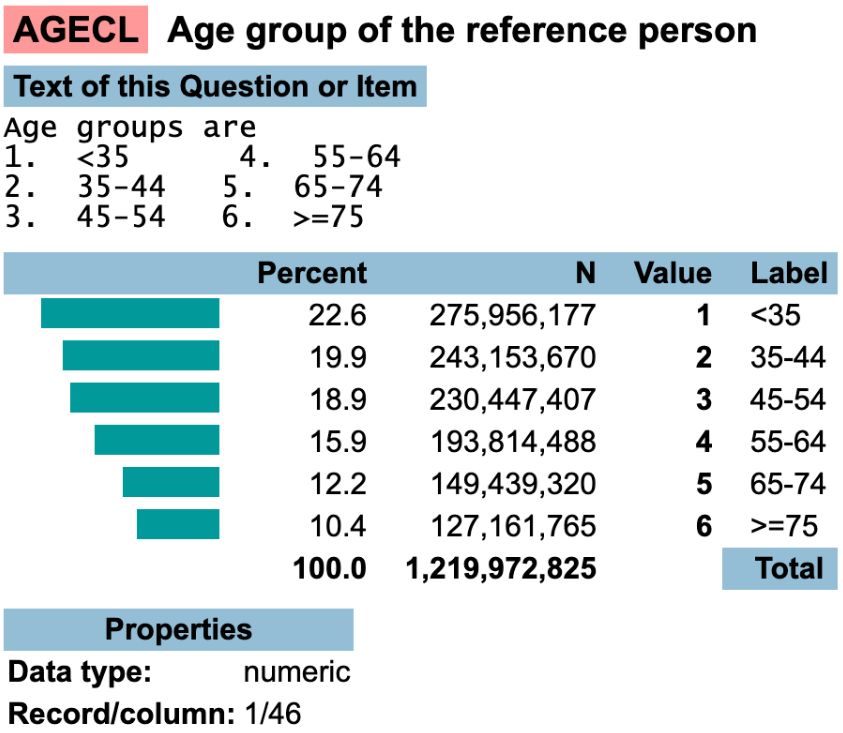

This simplifies data storage, but it's not very human-readable. So before we create a visualization, let's create a version of this column that uses the actual group names.

In [ ]:
 df_fear["AGECL"].head(10)



```
5      3
6      3
7      3
8      3
9      3
110    5
111    5
112    5
113    5
114    5
Name: AGECL, dtype: int64
```



In [ ]:
agecl_dict = {
    1: "Under 35",
    2: "35-44",
    3: "45-54",
    4: "55-64",
    5: "65-74",
    6: "75 or Older",
}

age_cl = df_fear["AGECL"].replace(agecl_dict)
age_cl.head(10)



```
5      45-54
6      45-54
7      45-54
8      45-54
9      45-54
110    65-74
111    65-74
112    65-74
113    65-74
114    65-74
Name: AGECL, dtype: object
```



In [ ]:
age_cl_value_counts = age_cl.value_counts()

# Bar plot of `age_cl_value_counts`
age_cl_value_counts.plot(kind="bar", xlabel="Age Group", ylabel="Frequency (count)", title="Credit Fearful: Age Groups");

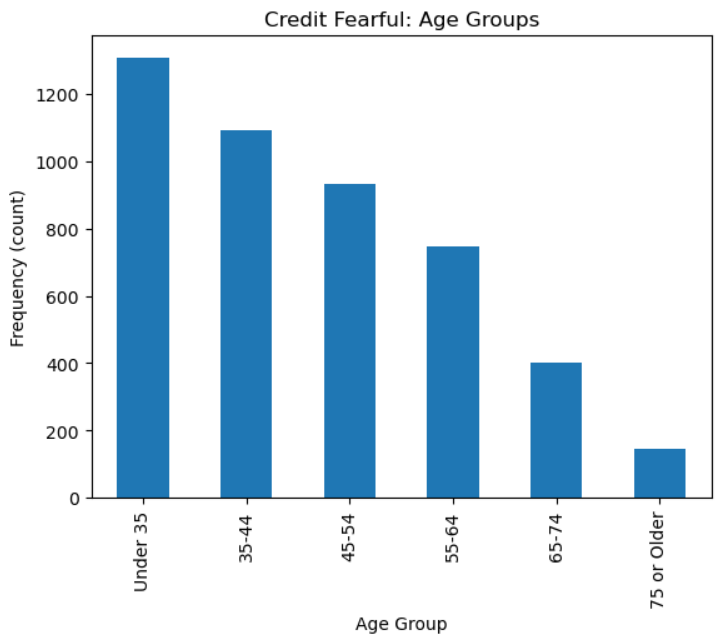

In [ ]:
# Plot histogram of "AGE"
df_fear["AGE"].hist(bins=10)
plt.xlabel("Age")
plt.ylabel("Frequency (count)")
plt.title("Credit Fearful: Age Distribution");

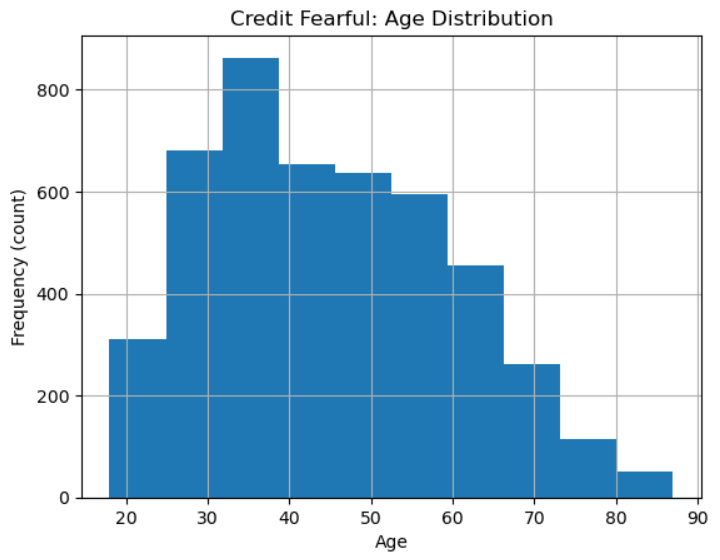

## Race

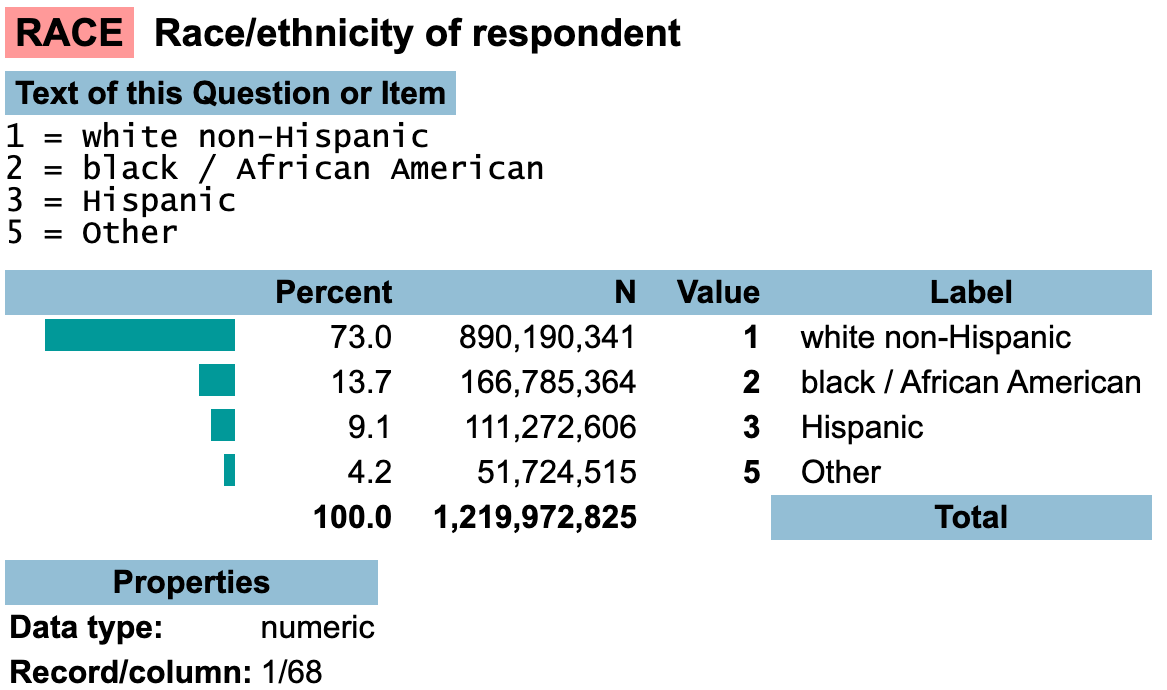

Note that there's no `4` category here. If a value for 4 *did* exist, it would be reasonable to assign it to "Asian American / Pacific Islander" — a group that doesn't seem to be represented in the dataset. This is a strange omission, but you'll often find that large public datasets have these sorts of issues. The important thing is to always read the data dictionary carefully. In this case, remember that this dataset doesn't provide a complete picture of race in America — something that you'd have to explain to anyone interested in your analysis.

In [ ]:
race_dict = {
    1: "White/Non-Hispanic",
    2: "Black/African-American",
    3: "Hispanic",
    5: "Other",
}
race = df_fear["RACE"].replace(race_dict)
race_value_counts = race.value_counts(normalize=True)
# Create bar chart of race_value_counts
race_value_counts.plot(kind="barh")
plt.xlim((0, 1))  # Min = 0, Max = 1
plt.xlabel("Frequency (%)")
plt.ylabel("Race")
plt.title("Credit Fearful: Racial Groups");

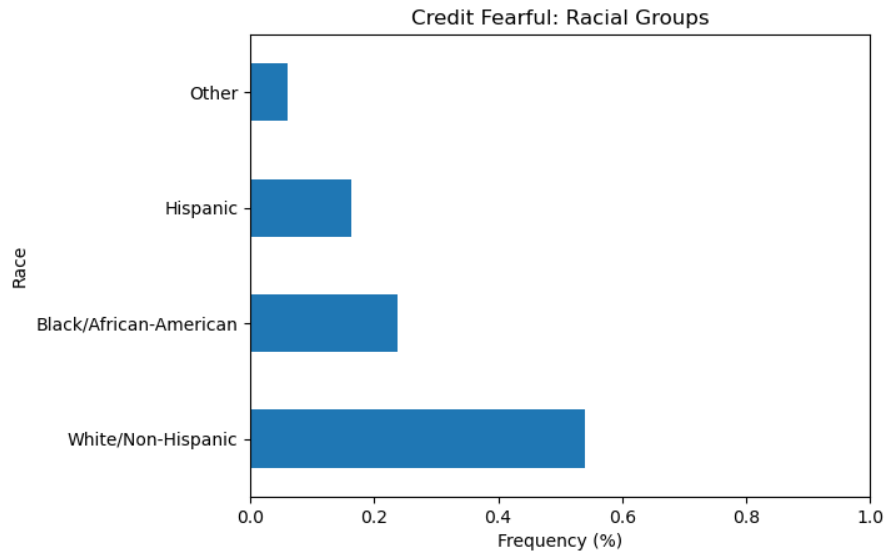

In [ ]:
race = df["RACE"].replace(race_dict)
race_value_counts = race.value_counts(normalize=True)
# Create bar chart of race_value_counts
race_value_counts.plot(kind="barh")
plt.xlim((0, 1))
plt.xlabel("Frequency (%)")
plt.ylabel("Race")
plt.title("SCF Respondents: Racial Groups");

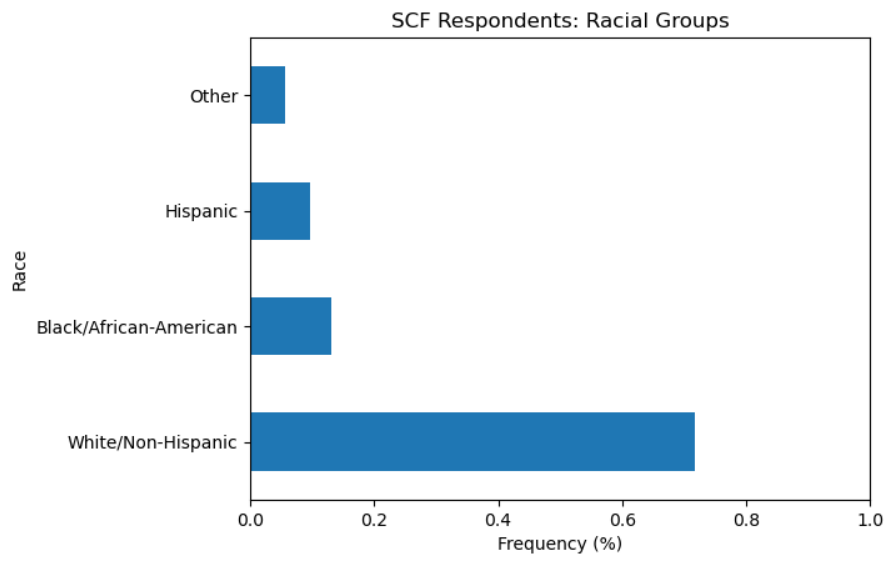

How does this second bar chart change our perception of the first one? On the one hand, we can see that White Non-Hispanics account for around 70% of whole dataset, but only 54% of credit fearful respondents. On the other hand, Black and Hispanic respondents represent 23% of the whole dataset but 40% of credit fearful respondents. In other words, Black and Hispanic households are actually *more* likely to be in the credit fearful group.

## Income

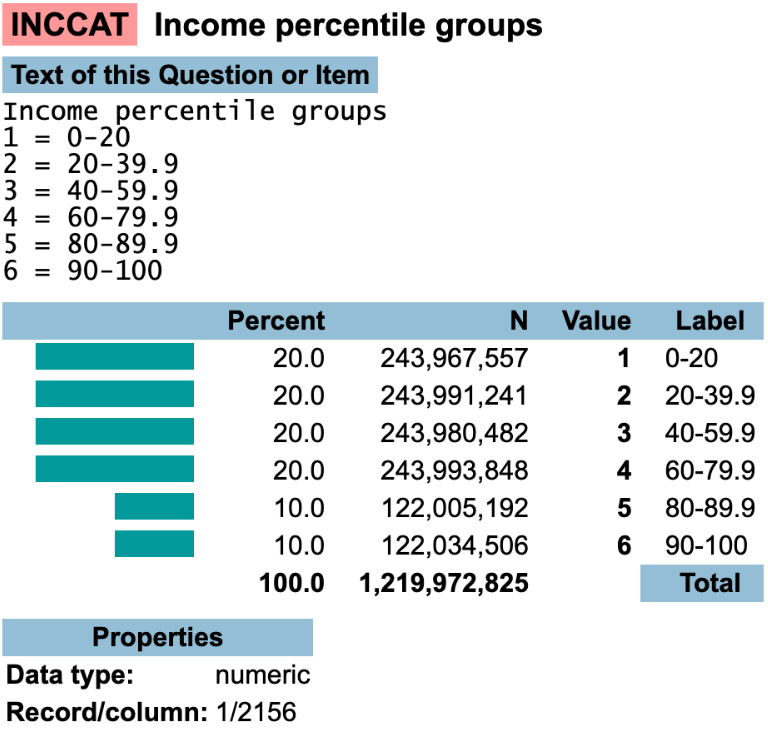

In [ ]:
inccat_dict = {
    1: "0-20",
    2: "21-39.9",
    3: "40-59.9",
    4: "60-79.9",
    5: "80-89.9",
    6: "90-100",
}

df_inccat = (
    df["INCCAT"]
    .replace(inccat_dict)
    .groupby(df["TURNFEAR"])
    .value_counts(normalize=True)
    .rename("frequency")
    .to_frame()
    .reset_index()
)

print("df_inccat type:", type(df_inccat))
print("df_inccat shape:", df_inccat.shape)
df_inccat

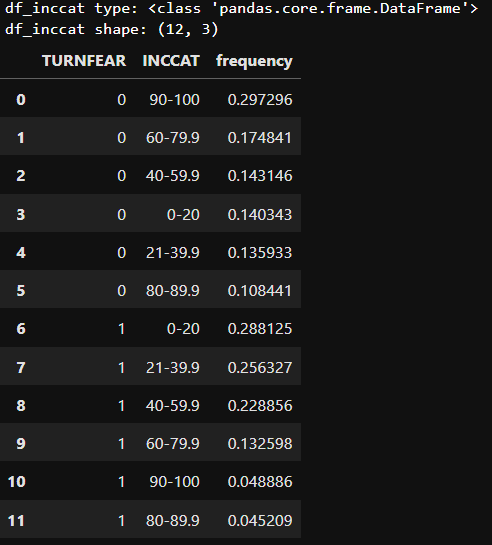

In [ ]:
# Create bar chart of `df_inccat`
sns.barplot(x="INCCAT", y="frequency", hue="TURNFEAR", data=df_inccat, order=inccat_dict.values()) # hue means color code according to (TURNFEAR in our case)
plt.xlabel("Income Category")
plt.ylabel("Frequency (%)")
plt.title("Income Distribution: Credit Fearful vs. Non-fearful");

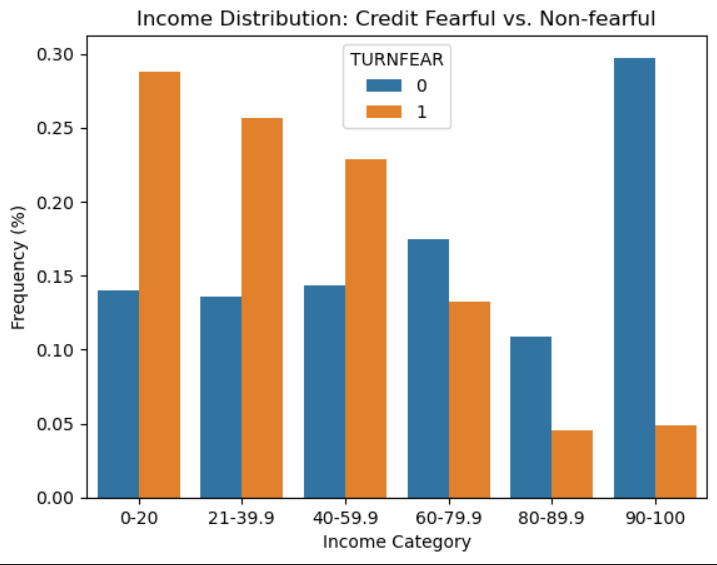

In [ ]:
asset_house_corr = df["ASSET"].corr(df["HOUSES"])
print("SCF: Asset Houses Correlation:", asset_house_corr)

SCF: Asset Houses Correlation: 0.5198273544779252

In [ ]:
asset_house_corr = df_fear["ASSET"].corr(df_fear["HOUSES"])
print("Credit Fearful: Asset Houses Correlation:", asset_house_corr)

Credit Fearful: Asset Houses Correlation: 0.5832879735979154

In [ ]:
cols = ["ASSET", "HOUSES", "INCOME", "DEBT", "EDUC"]
corr = df[cols].corr()
corr.style.background_gradient(axis=None)

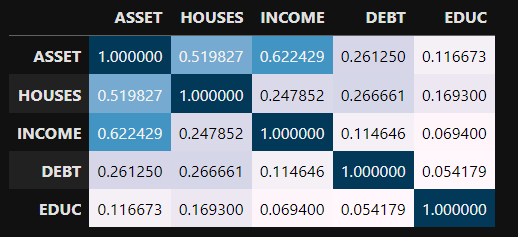

In [ ]:
corr = df_fear[cols].corr()
corr.style.background_gradient(axis=None)

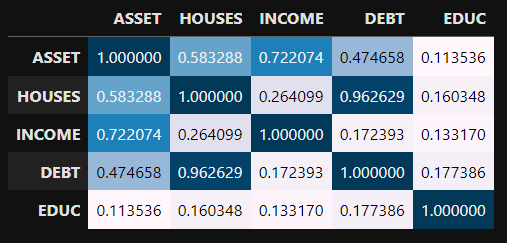

## Education

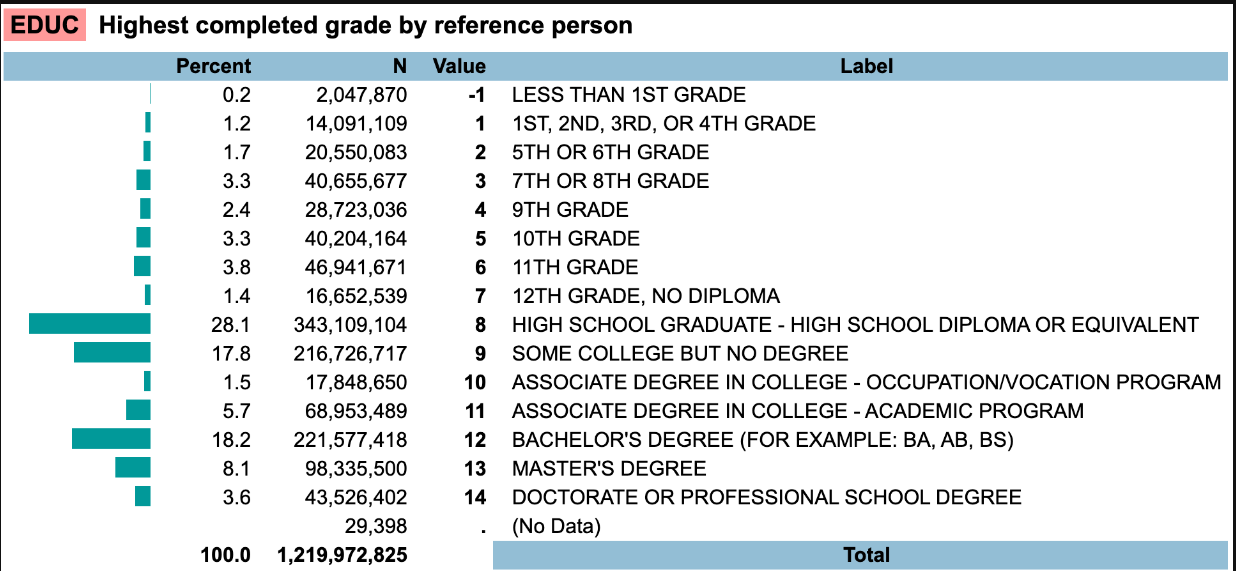

In [ ]:
df_educ = (
    df["EDUC"]
    .groupby(df["TURNFEAR"])
    .value_counts(normalize=True)
    .rename("frequency")
    .to_frame()
    .reset_index()
)
print("df_educ type:", type(df_educ))
print("df_educ shape:", df_educ.shape)
df_educ.head()

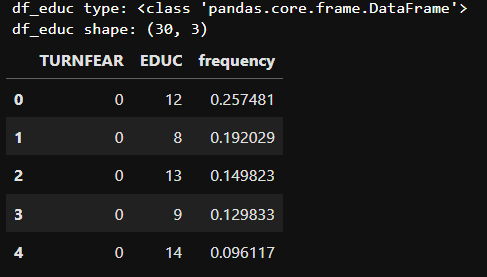

In [ ]:
# Create bar chart of `df_educ`
sns.barplot(x="EDUC", y="frequency", hue="TURNFEAR", data=df_educ)
plt.xlabel("Education Level")
plt.ylabel("Frequency (%)")
plt.title("Educational Attainment: Credit Fearful vs. Non-fearful");

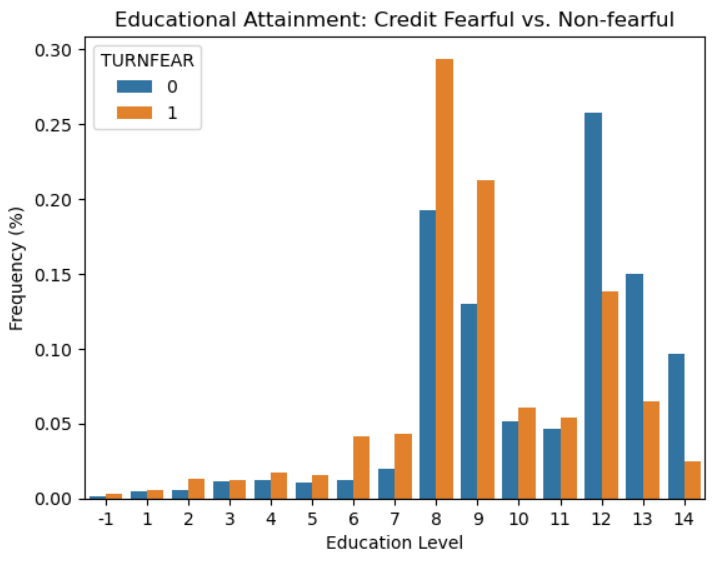

## Debt

In [ ]:
# Create scatter plot of ASSET vs DEBT, df
df.plot.scatter(x="DEBT", y="ASSET");

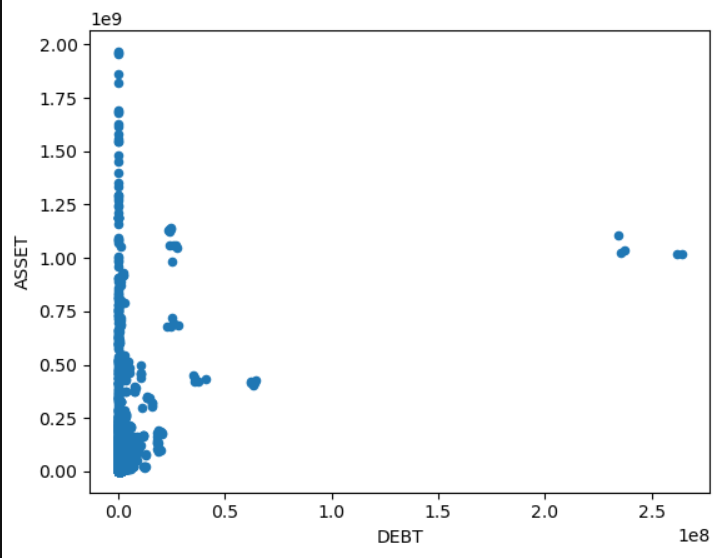

In [ ]:
# Create scatter plot of ASSET vs DEBT, df_fear
df_fear.plot.scatter(x="DEBT", y="ASSET");

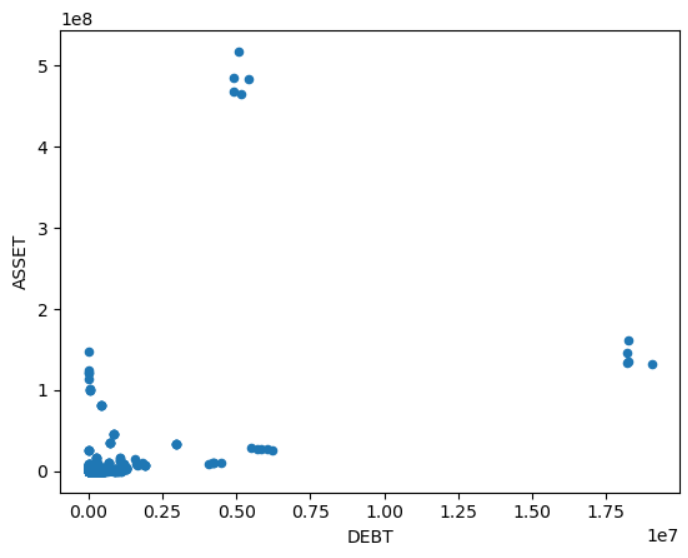

In [ ]:
# Create scatter plot of HOUSES vs DEBT, df
df.plot.scatter(x="DEBT", y="HOUSES");

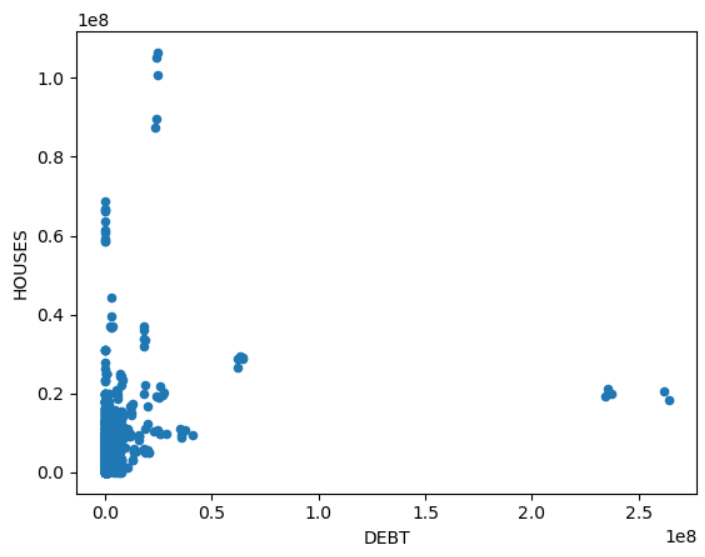

In [ ]:
# Create scatter plot of HOUSES vs DEBT, df_fear
df_fear.plot.scatter(x="DEBT", y="HOUSES");

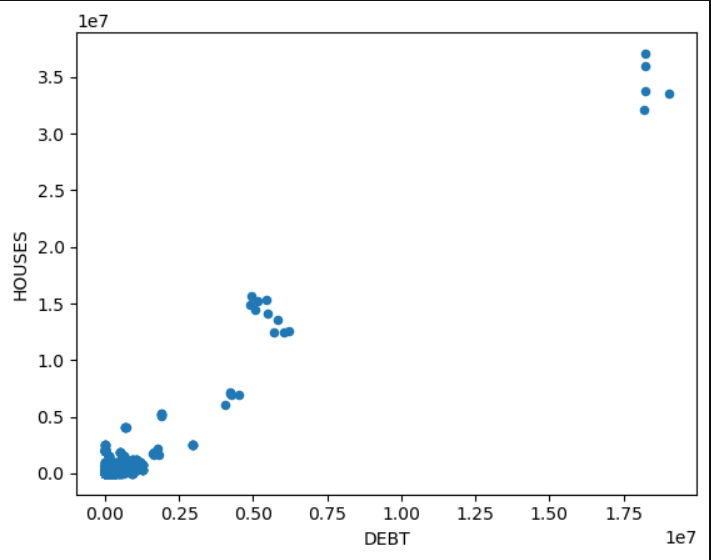

# Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    mask = df["TURNFEAR"] == 1
    df = df[mask]
    return df

In [ ]:
df = wrangle("data/SCFP2019.csv.gz")

In [ ]:
# Plot "HOUSES" vs "DEBT"
sns.scatterplot(x=df["DEBT"]/ 1e6, y=df["HOUSES"]/ 1e6)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

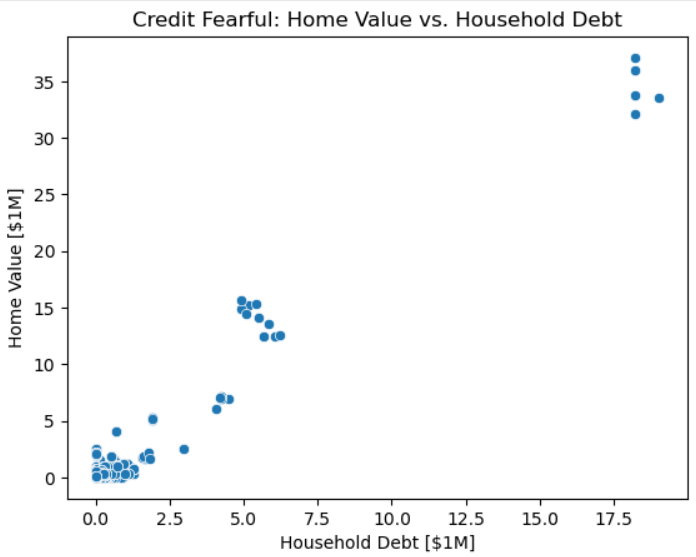

In [ ]:
X = df[["DEBT","HOUSES"]]
print("X shape:", X.shape)

X shape: (4623, 2)

In [ ]:
scfc = SCFClusterWidget(x=df["DEBT"], y=df["HOUSES"], n_clusters=3)
scfc.show()

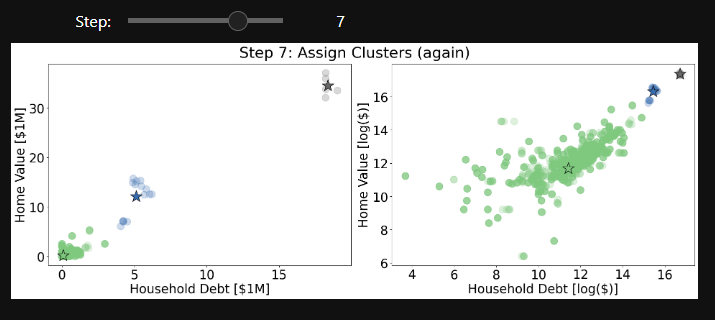

In [ ]:
# Build model
model = KMeans(n_clusters=3, random_state=42)


# Fit model to data
model.fit(X)

In [ ]:
labels = model.labels_

print("labels type:", type(labels))
print("labels shape:", labels.shape)
labels[:10]

labels type: <class 'numpy.ndarray'>

labels shape: (4623,)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [ ]:
centroids = model.cluster_centers_



```
centroids type: <class 'numpy.ndarray'>
centroids shape: (3, 2)
array([[   91017.57766674,   116150.29328698],
       [18384100.        , 34484000.        ],
       [ 5065800.        , 11666666.66666667]])
```
The first column represents the X of the centroid, and the second represents the Y.


In [ ]:
# Plot "HOUSES" vs "DEBT", add centroids
sns.scatterplot(
    x=df["DEBT"]/ 1e6,
    y=df["HOUSES"]/ 1e6,
    hue=labels,
    palette="deep"
)
plt.scatter(
    x=centroids[:,0] / 1e6,
    y=centroids[:,1] / 1e6,
    color="gray",
    marker="*",
    s=150
)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

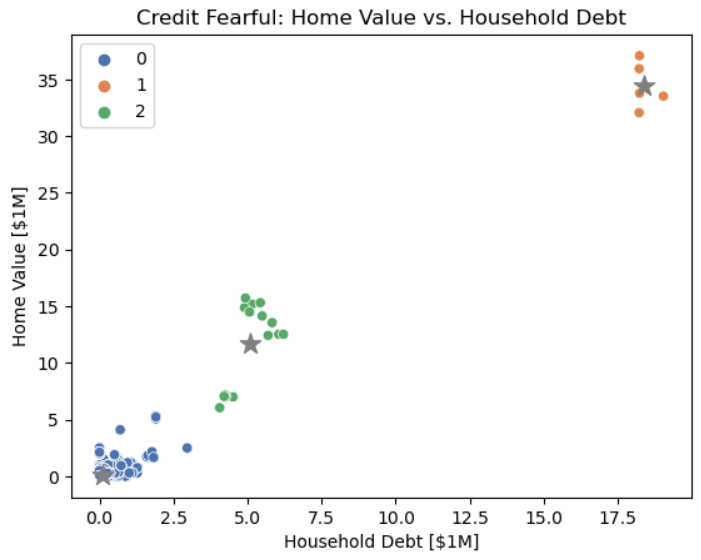

### Inertia

In [ ]:
inertia = model.inertia_

print("Inertia (3 clusters):", inertia)

Inertia (3 clusters): 939554010797059.4

The "best" inertia is 0, and our score is pretty far from that. Does that mean our model is "bad?" Not necessarily. Inertia is a measurement of distance (like mean absolute error from Project 2). This means that the unit of measurement for inertia depends on the unit of measurement of our x- and y-axes. And since `"DEBT"` and `"HOUSES"` are measured in tens of millions of dollars, it's not surprising that inertia is so large.

### Silhouette Score

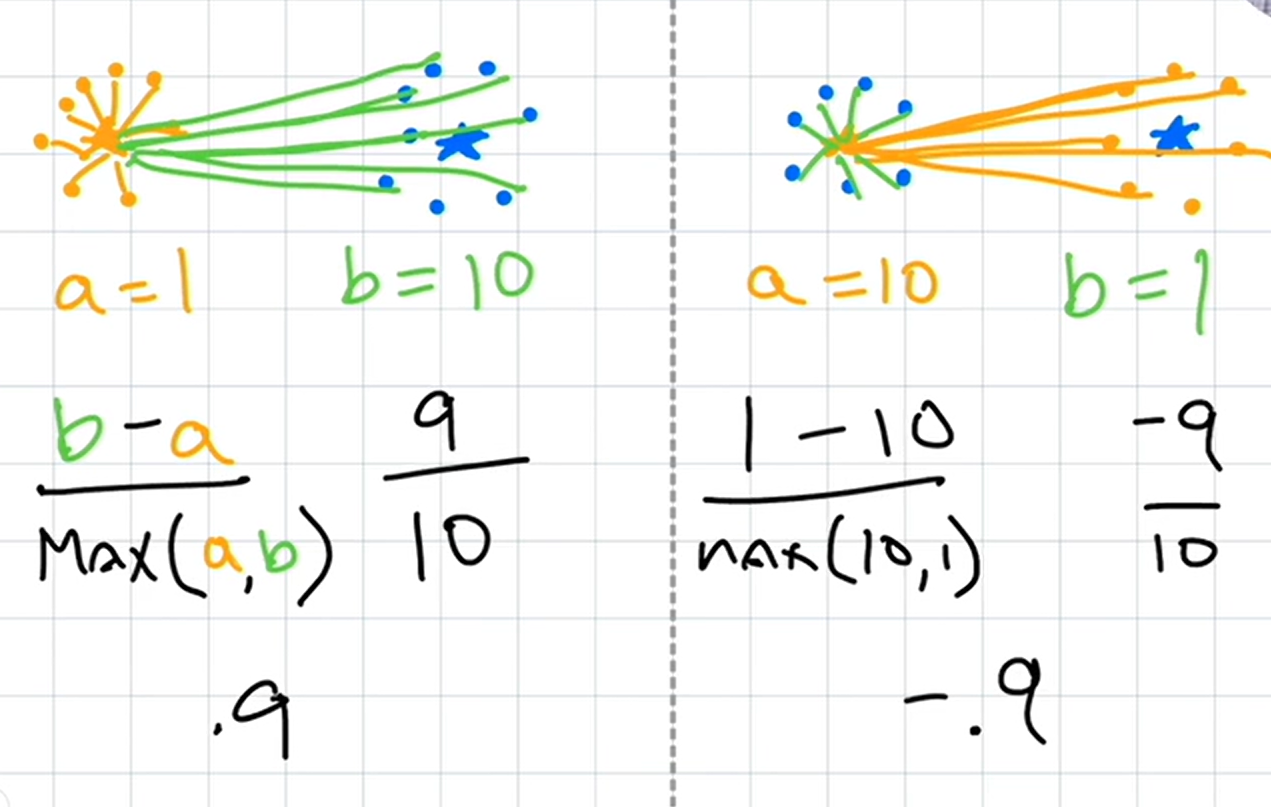

Silhouette score measures the distance *between different clusters*. It ranges from -1 (the worst) to 1 (the best), so it's easier to interpret than inertia.

In [ ]:
ss = silhouette_score(X, labels)

print("Silhouette Score (3 clusters):", ss)

Silhouette Score (3 clusters): 0.9768842462944348

In [ ]:
n_clusters = range(2, 13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    # Build model
    model = KMeans(n_clusters=k, random_state=42)
    # Train model
    model.fit(X)
    # Calculate inertia
    inertia_errors.append(model.inertia_)
    # Calculate ss
    silhouette_scores.append(silhouette_score(X, model.labels_))


In [ ]:
print("inertia_errors type:", type(inertia_errors))
print("inertia_errors len:", len(inertia_errors))
print("Inertia:", inertia_errors)
print()
print("silhouette_scores type:", type(silhouette_scores))
print("silhouette_scores len:", len(silhouette_scores))
print("Silhouette Scores:", silhouette_scores)



```
inertia_errors type: <class 'list'>
inertia_errors len: 11
Inertia: [3018038313336857.5, 939554010797059.4, 546098841715646.25, 309313172681861.4, 235250007188435.38, 182185545995311.7, 150727950872604.22, 114321995931021.89, 100488983856739.94, 86227397125225.02, 73193859398329.2]

silhouette_scores type: <class 'list'>
silhouette_scores len: 11
Silhouette Scores: [0.9855099957519555, 0.9768842462944348, 0.9490311483406091, 0.839669623678179, 0.7526801280714244, 0.7277940458463407, 0.7256332651512161, 0.7335125606476427, 0.7313509140373811, 0.6950363232867054, 0.6964839563551604]
```



In [ ]:
# Plot `inertia_errors` by `n_clusters`
plt.plot(n_clusters, inertia_errors)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("K-Means Model: Inertia vs Number of Clusters");

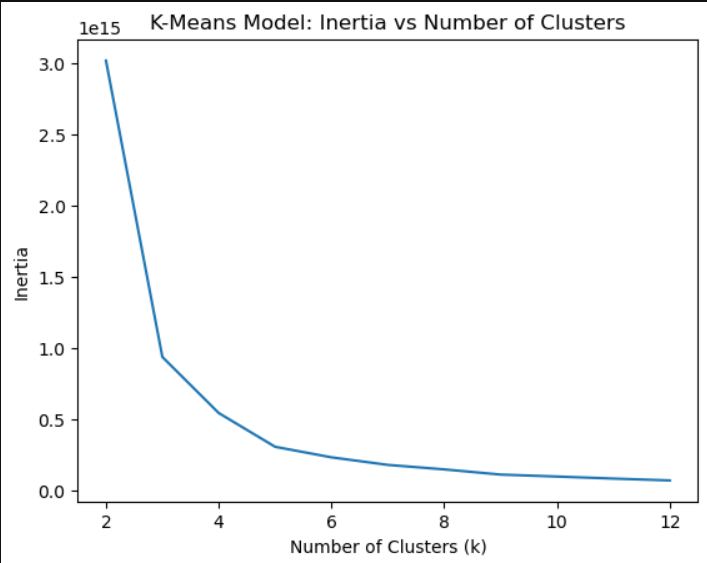

The trick with choosing the right number of clusters is to look for the "bend in the elbow" for this plot. In other words, we want to pick the point where the drop in inertia becomes less dramatic and the line begins to flatten out. In this case, it looks like the sweet spot is 4 or 5.

In [ ]:
# Plot `silhouette_scores` vs `n_clusters`
plt.plot(n_clusters, silhouette_scores)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("K-Means Model: Silhouette Score vs Number of Clusters");

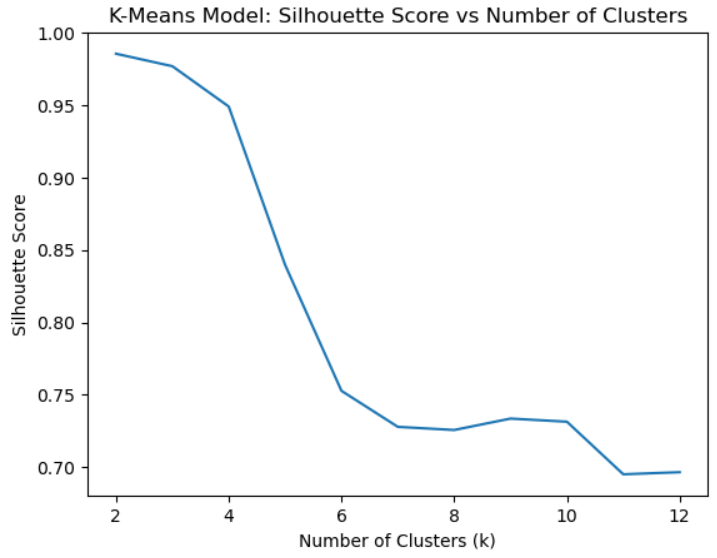

Note that, in contrast to our inertia plot, bigger is better. So we're not looking for a "bend in the elbow" but rather a number of clusters for which the silhouette score still remains high. We can see that silhouette score drops drastically beyond 4 clusters. Given this and what we saw in the inertia plot, it looks like the optimal number of clusters is 4.

In [ ]:
# Build model
final_model = KMeans(n_clusters=4, random_state=42)

# Fit model to data
final_model.fit(X)

In [ ]:
# Plot "HOUSES" vs "DEBT" with final_model labels
sns.scatterplot(
    x=df["DEBT"]/ 1e6,
    y=df["HOUSES"]/ 1e6,
    hue=final_model.labels_,
    palette="deep"
)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

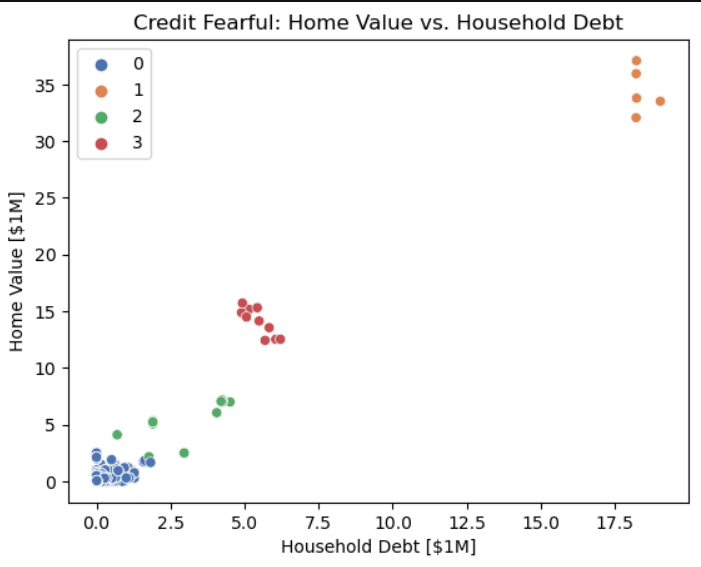

In [ ]:
xgb = X.groupby(final_model.labels_).mean()

print("xgb type:", type(xgb))
print("xgb shape:", xgb.shape)
xgb

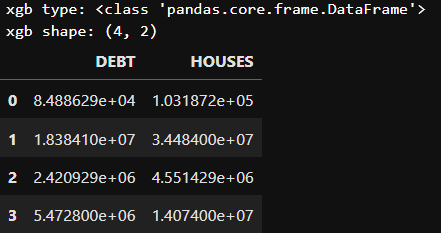

In [ ]:
# Create side-by-side bar chart of `xgb`
(xgb/1e6).plot(kind="bar")
plt.xlabel("Cluster")
plt.ylabel("Value [$1 million]")
plt.title("Mean Home Value & Household Debt by Cluster");

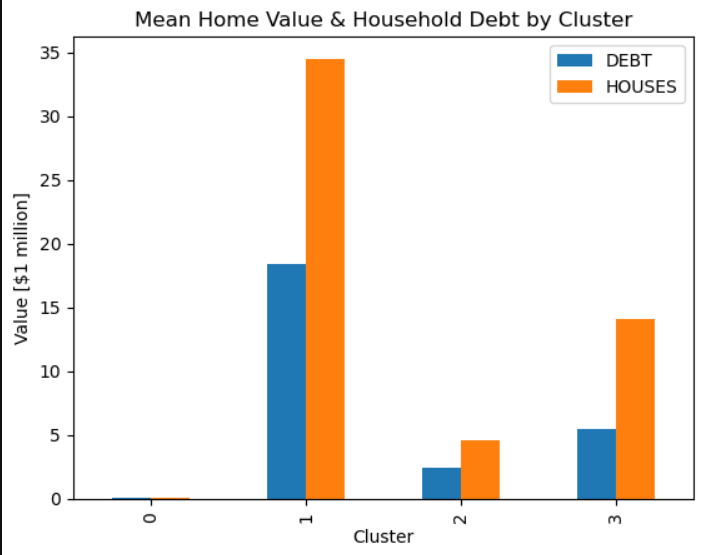

# Clustering with Multiple Features

In [ ]:
import plotly.express as px
from scipy.stats.mstats import trimmed_var
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
def wrangle(filepath):
    df = pd.read_csv(filepath)
    mask = (df["TURNFEAR"] == 1) & (df["NETWORTH"] < 2e6)
    df = df[mask]
    return df

In [ ]:
# Calculate variance, get 10 largest features
top_ten_var = df.var().sort_values().tail(10)

In [ ]:
# Create horizontal bar chart of `top_ten_var`
fig = px.bar(
    x=top_ten_var,
    y=top_ten_var.index,
    title="SCF: High Variance Features"
)
fig.update_layout(xaxis_title="Variance", yaxis_title="Feature")
fig.show()

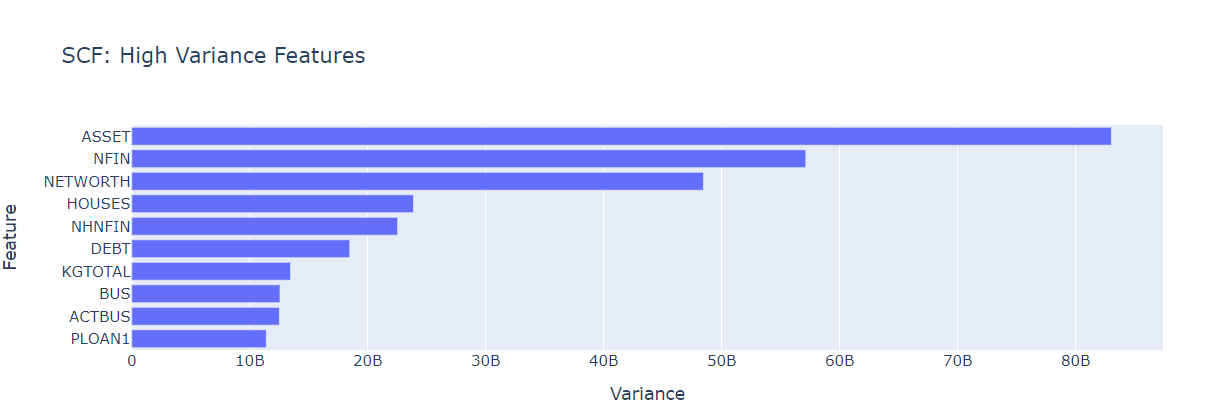

In [ ]:
# Create a boxplot of `NHNFIN`
fig = px.box(
    data_frame=df,
    x="NHNFIN",
    title="Distribution of Non-home, Non-Financial Assets"
)
fig.update_layout(xaxis_title="Value [$]")
fig.show()

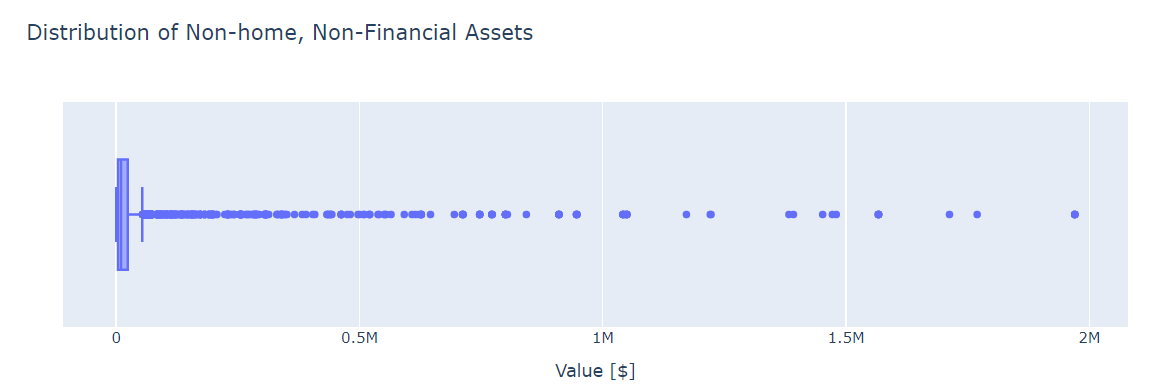

The dataset is massively right-skewed because of the huge outliers on the right side of the distribution. Even though we already excluded households with a high net worth with our `wrangle` function, the variance is still being distorted by some extreme outliers.

The best way to deal with this is to look at the **trimmed variance**, where we remove extreme values before calculating variance. We can do this using the `trimmed_variance` function from the `SciPy` library.

In [ ]:
# Calculate trimmed variance
top_ten_trim_var = df.apply(trimmed_var).sort_values().tail(10)

`trimmed_var` can't be used on a DataFrame, so we use the `apply()` method to make it work on a DF.

Note : we don't use a set of parenthesis inside the `apply()` method.

In [ ]:
# Create horizontal bar chart of `top_ten_trim_var`
fig = px.bar(
    x=top_ten_trim_var,
    y=top_ten_trim_var.index,
    title="SCF: High Variance Features"
)
fig.update_layout(xaxis_title="Trimmed Variance", yaxis_title="Feature")
fig.show()

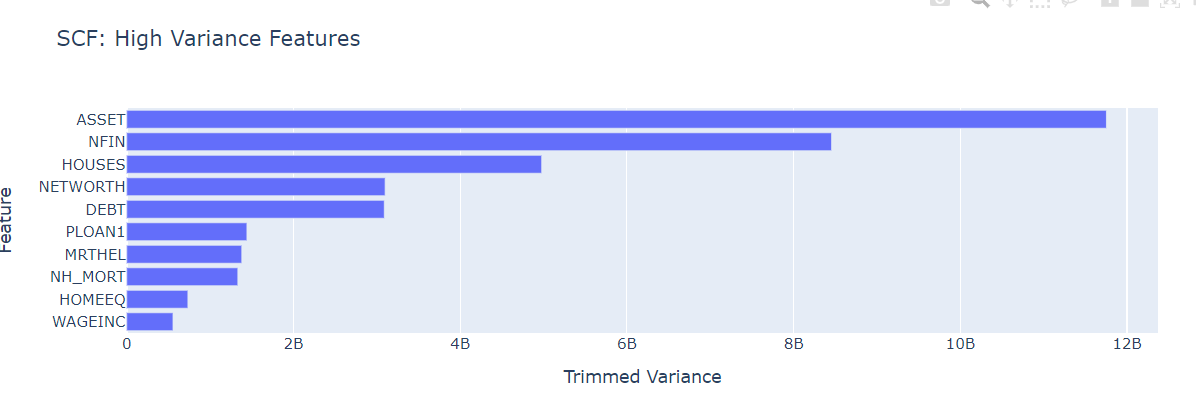

There are three things to notice in this plot. First, the variances have decreased a lot. In our previous chart, the x-axis went up to \\$80 billion; this one goes up to \\$12 billion. Second, the top 10 features have changed a bit. All the features relating to business ownership (`"...BUS"`) are gone. Finally, we can see that there are big differences in variance from feature to feature. For example, the variance for `"WAGEINC"` is around than \\$500 million, while the variance for `"ASSET"` is nearly \\$12 billion. In other words, these features have completely different scales. This is something that we'll need to address before we can make good clusters.

**Task 6.3.7:** Generate a list `high_var_cols` with the column names of the  five features with the highest trimmed variance.

In [ ]:
high_var_cols = top_ten_trim_var.tail().index.to_list()
high_var_cols

['DEBT', 'NETWORTH', 'HOUSES', 'NFIN', 'ASSET']

In [ ]:
X = df[high_var_cols]

print("X type:", type(X))
print("X shape:", X.shape)
X.head()

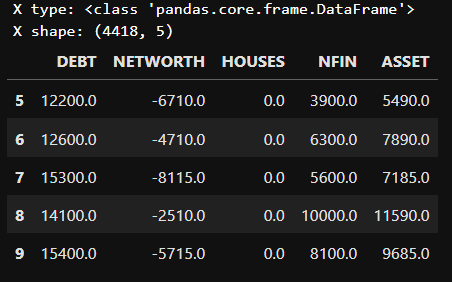

In [ ]:
X_summary = X.aggregate(["mean","std"]).astype(int)

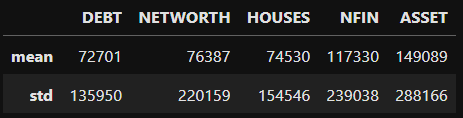

In [ ]:
# Instantiate transformer
ss = StandardScaler()

# Transform `X`
X_scaled_data = ss.fit_transform(X)

# Put `X_scaled_data` into DataFrame
X_scaled = pd.DataFrame(X_scaled_data, columns=X.columns)

In [ ]:
X_scaled_summary = X_scaled.aggregate(["mean","std"]).astype(int)

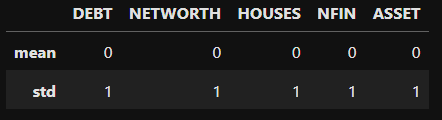

In [ ]:
n_clusters = range(2,13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    #Buil model
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    # Train model
    model.fit(X)
    # Calculate inertia
    inertia_errors.append(model.named_steps["kmeans"].inertia_)
    # Calculate silhouette scores
    silhouette_scores.append(silhouette_score(X, model.named_steps["kmeans"].labels_))

In [ ]:
# Create line plot of `inertia_errors` vs `n_clusters`
fig = px.line(
    x=n_clusters, y=inertia_errors, title="K-Means Model: Inertia vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Inertia")
fig.show()

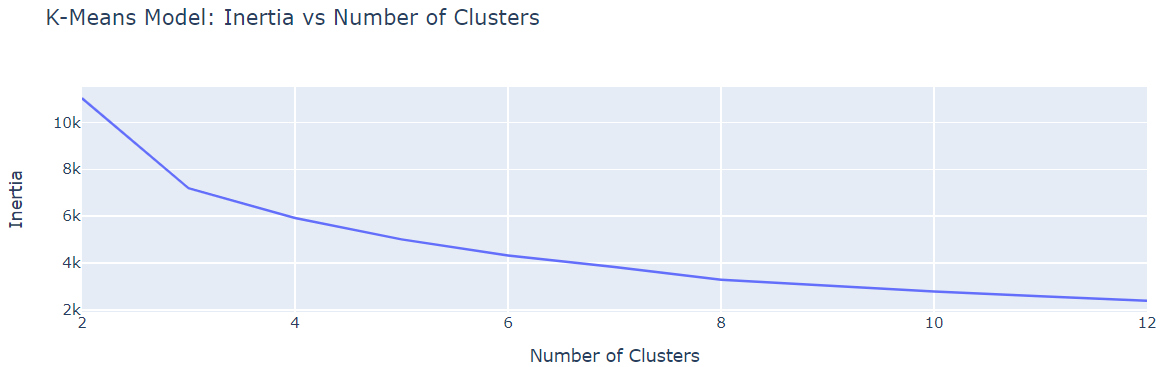

In [ ]:
# Create a line plot of `silhouette_scores` vs `n_clusters`
fig = px.line(
    x=n_clusters, y=silhouette_scores, title="K-Means Model: Silhouette Score vs Number of Clusters"
)
fig.update_layout(xaxis_title="Number of Clusters", yaxis_title="Silhouette Score")
fig.show()

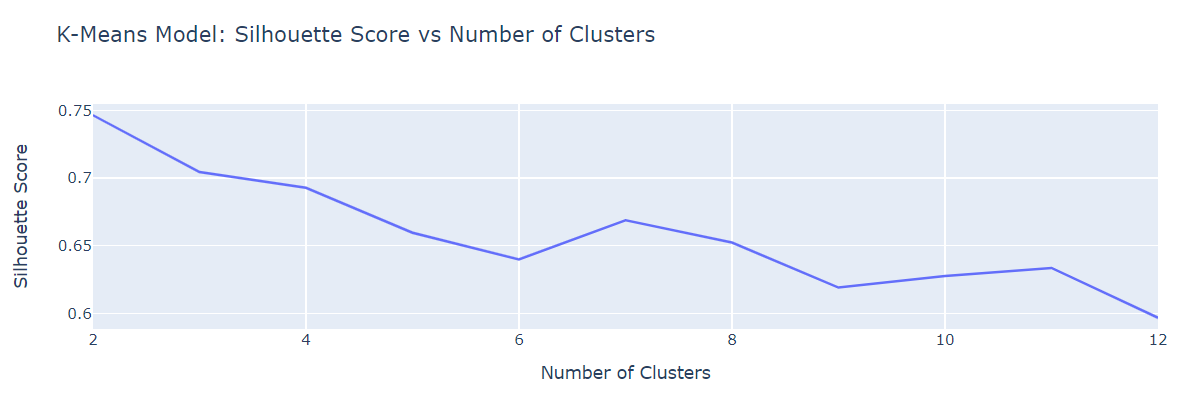

In [ ]:
# Build model
final_model = make_pipeline(StandardScaler(), KMeans(n_clusters=4, random_state=42))

# Fit model to data
final_model.fit(X)

In [ ]:
labels = final_model.named_steps["kmeans"].labels_

In [ ]:
xgb = X.groupby(labels).mean()

In [ ]:
# Create side-by-side bar chart of `xgb`
fig = px.bar(
    xgb,
    barmode="group",
    title="Mean Household Finances by Cluster"
)
fig.update_layout(xaxis_title="Cluster", yaxis_title="Value [$]")
fig.show()

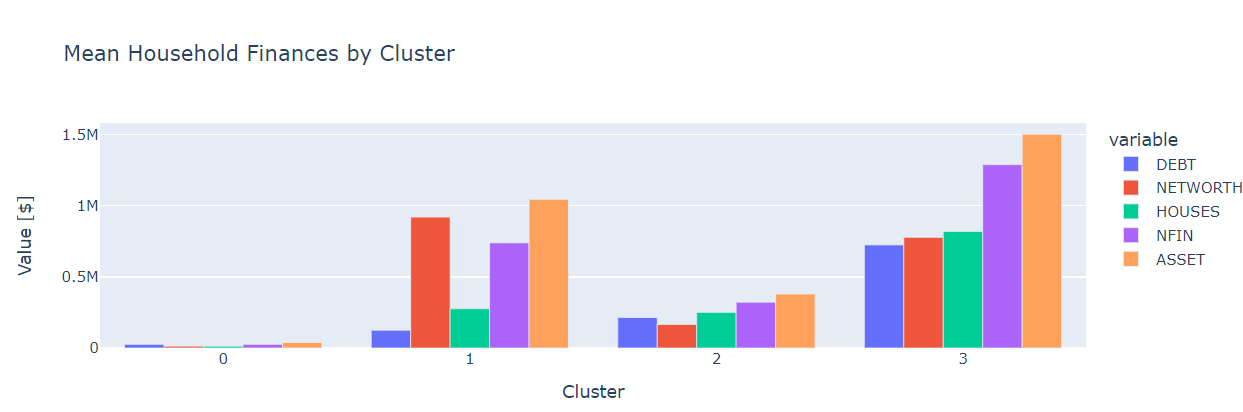

In [ ]:
# Instantiate transformer
pca = PCA(n_components=2, random_state=42)

# Transform `X`
X_t = pca.fit_transform(X)

# Put `X_t` into DataFrame
X_pca = pd.DataFrame(X_t, columns=["PC1","PC2"])

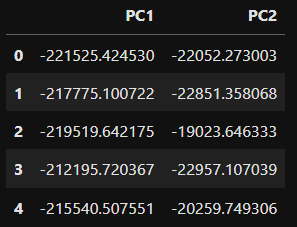

In [ ]:
# Create scatter plot of `PC2` vs `PC1`
fig = px.scatter(
    data_frame=X_pca,
    x="PC1",
    y="PC2",
    color=labels.astype(str), # like hue in sns
    title="PCA Representation of Clusters"
)
fig.update_layout(xaxis_title="PC1", yaxis_title="PC2")
fig.show()

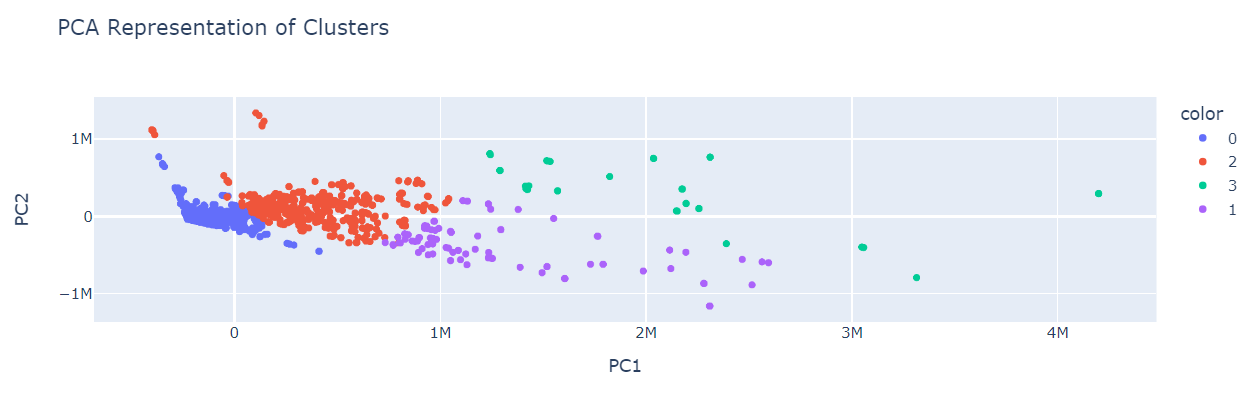

# Interactive Dashboard

In [ ]:
from jupyter_dash import JupyterDash

In [ ]:
app = JupyterDash(__name__) # grabs the name of the file where we are currently

## Variance Bar Chart

In [ ]:
def get_high_var_features(trimmed=True, return_feat_names=True):

    """Returns the five highest-variance features of ``df``.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    return_feat_names : bool, default=False
        If ``True``, returns feature names as a ``list``. If ``False``
        returns ``Series``, where index is feature names and values are
        variances.
    """
    # Calculate variance
    if trimmed :
        top_five_features = df.apply(trimmed_var).sort_values().tail()

    else:
        top_five_features = df.var().sort_values().tail()

    # Extract names
    if return_feat_names:
        top_five_features = top_five_features.index.to_list()

    return top_five_features

In [ ]:
@app.callback(
    Output("bar-chart", "figure"), Input("trim-button", "value")
)
def serve_bar_chart(trimmed=True):

    """Returns a horizontal bar chart of five highest-variance features.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.
    """
    # Get features
    top_five_features = get_high_var_features(trimmed=trimmed, return_feat_names=False)

    # Build bar chart
    fig = px.bar(x=top_five_features, y=top_five_features.index, orientation="h")
    fig.update_layout(xaxis_title="Variance", yaxis_title="Feature")

    return fig

## K-means Slider and Metrics

In [ ]:
def get_model_metrics(trimmed=True, k=2, return_metrics=False):

    """Build ``KMeans`` model based on five highest-variance features in ``df``.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.

    return_metrics : bool, default=False
        If ``False`` returns ``KMeans`` model. If ``True`` returns ``dict``
        with inertia and silhouette score.

    """
    # Get high var features
    features = get_high_var_features(trimmed=trimmed, return_feat_names=True)
    # Create feature matrix
    X = df[features]
    # Build model
    model = make_pipeline(StandardScaler(), KMeans(n_clusters=k, random_state=42))
    model.fit(X)

    if return_metrics:
        # Calculate inertia
        i = model.named_steps["kmeans"].inertia_
        # Calculate silhouette score
        ss = silhouette_score(X, model.named_steps["kmeans"].labels_)
        # put results into dictionnary
        metrics = {
            "inertia": round(i),
            "silhouette": round(ss,3)
        }
        # return dict to user
        return metrics

    return model

In [ ]:
@app.callback(
    Output("metrics", "children"),
    Input("trim-button", "value"),
    Input("k-slider", "value")
)
def serve_metrics(trimmed=True, k=2):

    """Returns list of ``H3`` elements containing inertia and silhouette score
    for ``KMeans`` model.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.
    """
    # get metrics
    metrics = get_model_metrics(trimmed=trimmed, k=k, return_metrics=True)

    # Add metrics to html elements
    text = [
        html.H3(f"Inertia: {metrics['inertia']}"),
        html.H3(f"Silhouette Score: {metrics['silhouette']}")
    ]
    return text

## PCA Scatter Plot

In [ ]:
def get_pca_labels(trimmed=True, k=2):

    """
    ``KMeans`` labels.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.
    """
    # Create feature matrix
    features = get_high_var_features(trimmed=trimmed, return_feat_names=True)
    X = df[features]

    # Build transformer
    transformer = PCA(n_components=2, random_state=42)
    X_t = transformer.fit_transform(X)
    X_pca = pd.DataFrame(X_t, columns=["PC1","PC2"])

    # Add labels
    model = get_model_metrics(trimmed=trimmed, k=k, return_metrics=False)
    X_pca["labels"] = model.named_steps["kmeans"].labels_.astype(str)
    X_pca.sort_values("labels",inplace=True)

    return X_pca

In [ ]:
@app.callback(
    Output("pca-scatter", "figure"),
    Input("trim-button", "value"),
    Input("k-slider", "value")
)
def serve_scatter_plot(trimmed=True, k=2):

    """Build 2D scatter plot of ``df`` with ``KMeans`` labels.

    Parameters
    ----------
    trimmed : bool, default=True
        If ``True``, calculates trimmed variance, removing bottom and top 10%
        of observations.

    k : int, default=2
        Number of clusters.
    """
    fig = px.scatter(
    data_frame=get_pca_labels(trimmed=trimmed, k=k),
    x="PC1",
    y="PC2",
    color="labels",
    title="PCA Representation of Clusters"
    )
    fig.update_layout(xaxis_title="PC1",yaxis_title="PC2")
    return fig

## Application

In [ ]:
app.layout = html.Div(
    [
        # Application title
        html.H1("Survey of Consumer Finances"),
        # Bar chart element
        html.H2("High Variance Features"),
        # Bar chart graph
        dcc.Graph(id="bar-chart"),
        dcc.RadioItems(
            options=[
                {"label": "trimmed", "value": True},
                {"label": "not trimmed", "value": False}
            ],
            value=True,
            id="trim-button"
        ),
        # K-means slider
        html.H2("K-means Clustering"),
        html.H3("Number of Clusters (k)"),
        dcc.Slider(min=2, max=12, step=1, value=2, id="k-slider"),
        html.Div(id="metrics"),
        # PCA Scatter plot
        dcc.Graph(id="pca-scatter")
    ]
)

https://vm.wqu.edu/proxy/8050/

Look at video : Dash.mp4